# Functional urban area (FUAs) projection

Project central european functional urban areas onto 2 PCA components, based on the distribution of urban fabric types within each FUA.

In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
mapping = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v3.pq"
)

In [13]:
fuas = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)

In [14]:
fuas

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry
252,8.0,1.0,2788,Innsbruck,1.0,AUT,Austria,352.0,27.0,244610.309811,113300.718506,131309.591305,"MULTIPOLYGON (((4443566.755 2690941.982, 44454..."
253,199.0,1.0,2885,Salzburg,1.0,AUT,Austria,368.0,46.0,261062.845268,140052.170959,121010.674308,"MULTIPOLYGON (((4560286.656 2759415.026, 45612..."
254,361.0,1.0,2936,Linz,1.0,AUT,Austria,875.0,69.0,417919.471337,202651.519836,215267.951500,"MULTIPOLYGON (((4645121.405 2822486.965, 46536..."
255,511.0,1.0,2952,Klagenfurt,1.0,AUT,Austria,462.0,26.0,152986.515700,64018.369995,88968.145705,"MULTIPOLYGON (((4656176.355 2638266.258, 46571..."
256,654.0,1.0,3000,Graz,1.0,AUT,Austria,978.0,73.0,441137.873177,261476.193604,179661.679573,"MULTIPOLYGON (((4723593.134 2695741.13, 472455..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7673,327.0,1.0,3104,Trnava,1.0,SVK,Slovakia,537.0,16.0,139857.330934,52550.098022,87307.232911,"MULTIPOLYGON (((4875444.247 2848478.714, 48801..."
7674,480.0,1.0,3155,Žilina,1.0,SVK,Slovakia,534.0,21.0,181681.640991,61025.274475,120656.366516,"MULTIPOLYGON (((4961408.815 2951386.993, 49604..."
7675,623.0,1.0,3182,Banská Bystrica,1.0,SVK,Slovakia,323.0,22.0,126248.723860,59149.840820,67098.883040,"MULTIPOLYGON (((4989472.704 2899534.991, 49904..."
7676,760.0,1.0,3265,Prešov,1.0,SVK,Slovakia,425.0,20.0,162125.056025,66394.822998,95730.233027,"MULTIPOLYGON (((5129516.429 2949839.008, 51304..."


Assign a FUA identifier for every building.

In [4]:
%%time

results = []

for region_id in regions.index:
    
    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_v3.pq')
    
    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 2min 1s, sys: 10.2 s, total: 2min 11s
Wall time: 1min 58s


In [5]:
all_fua_buildings.iloc[:1000].explore()

Assign cluster identifiers at a specified level for every building,  aggregate the building data to functional areas, calculate the distribution of urban fabric clusters and compute the principle components.

In [16]:
def generate_pca_plot_at_level(building_data, level):
    """Generate a PCA dataframe from a building data frame"""
    
    # Assign cluster identifiers at a specified level for every building 
    subset = building_data[['country', 'city', 'final_without_noise']]
    if level < 7:
        subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())
    
    # aggregate the building data to functional areas
    res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
    res = res.unstack(-1).fillna(0).astype(int)
    
    # normalise based on counts
    # note: normalisation can be based on building area too
    X = res.values / res.sum(axis=1).values[:, np.newaxis]

    # compute the PCs and return the results
    pca = PCA(n_components=3)
    components = pca.fit_transform(X)
    print(pca.explained_variance_, pca.explained_variance_ratio_)
    df = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3'])
    df.loc[:, 'city'] = res.index.get_level_values(1).values
    df.loc[:, 'country'] = res.index.get_level_values(0).values
    return df

[0.01710804 0.00593765 0.00471977] [0.31507762 0.10935323 0.08692371]
[0.02585014 0.00727252 0.00520662] [0.40633962 0.11431717 0.08184317]
[0.03579096 0.01161795 0.00646683] [0.47265887 0.1534278  0.08540164]
[0.05708079 0.01390008 0.00800713] [0.58355179 0.14210415 0.081859  ]
[0.05542404 0.01639664 0.01143843] [0.59833616 0.17701171 0.12348475]
[0.08052376 0.0185778  0.01042493] [0.73519897 0.16961921 0.09518182]


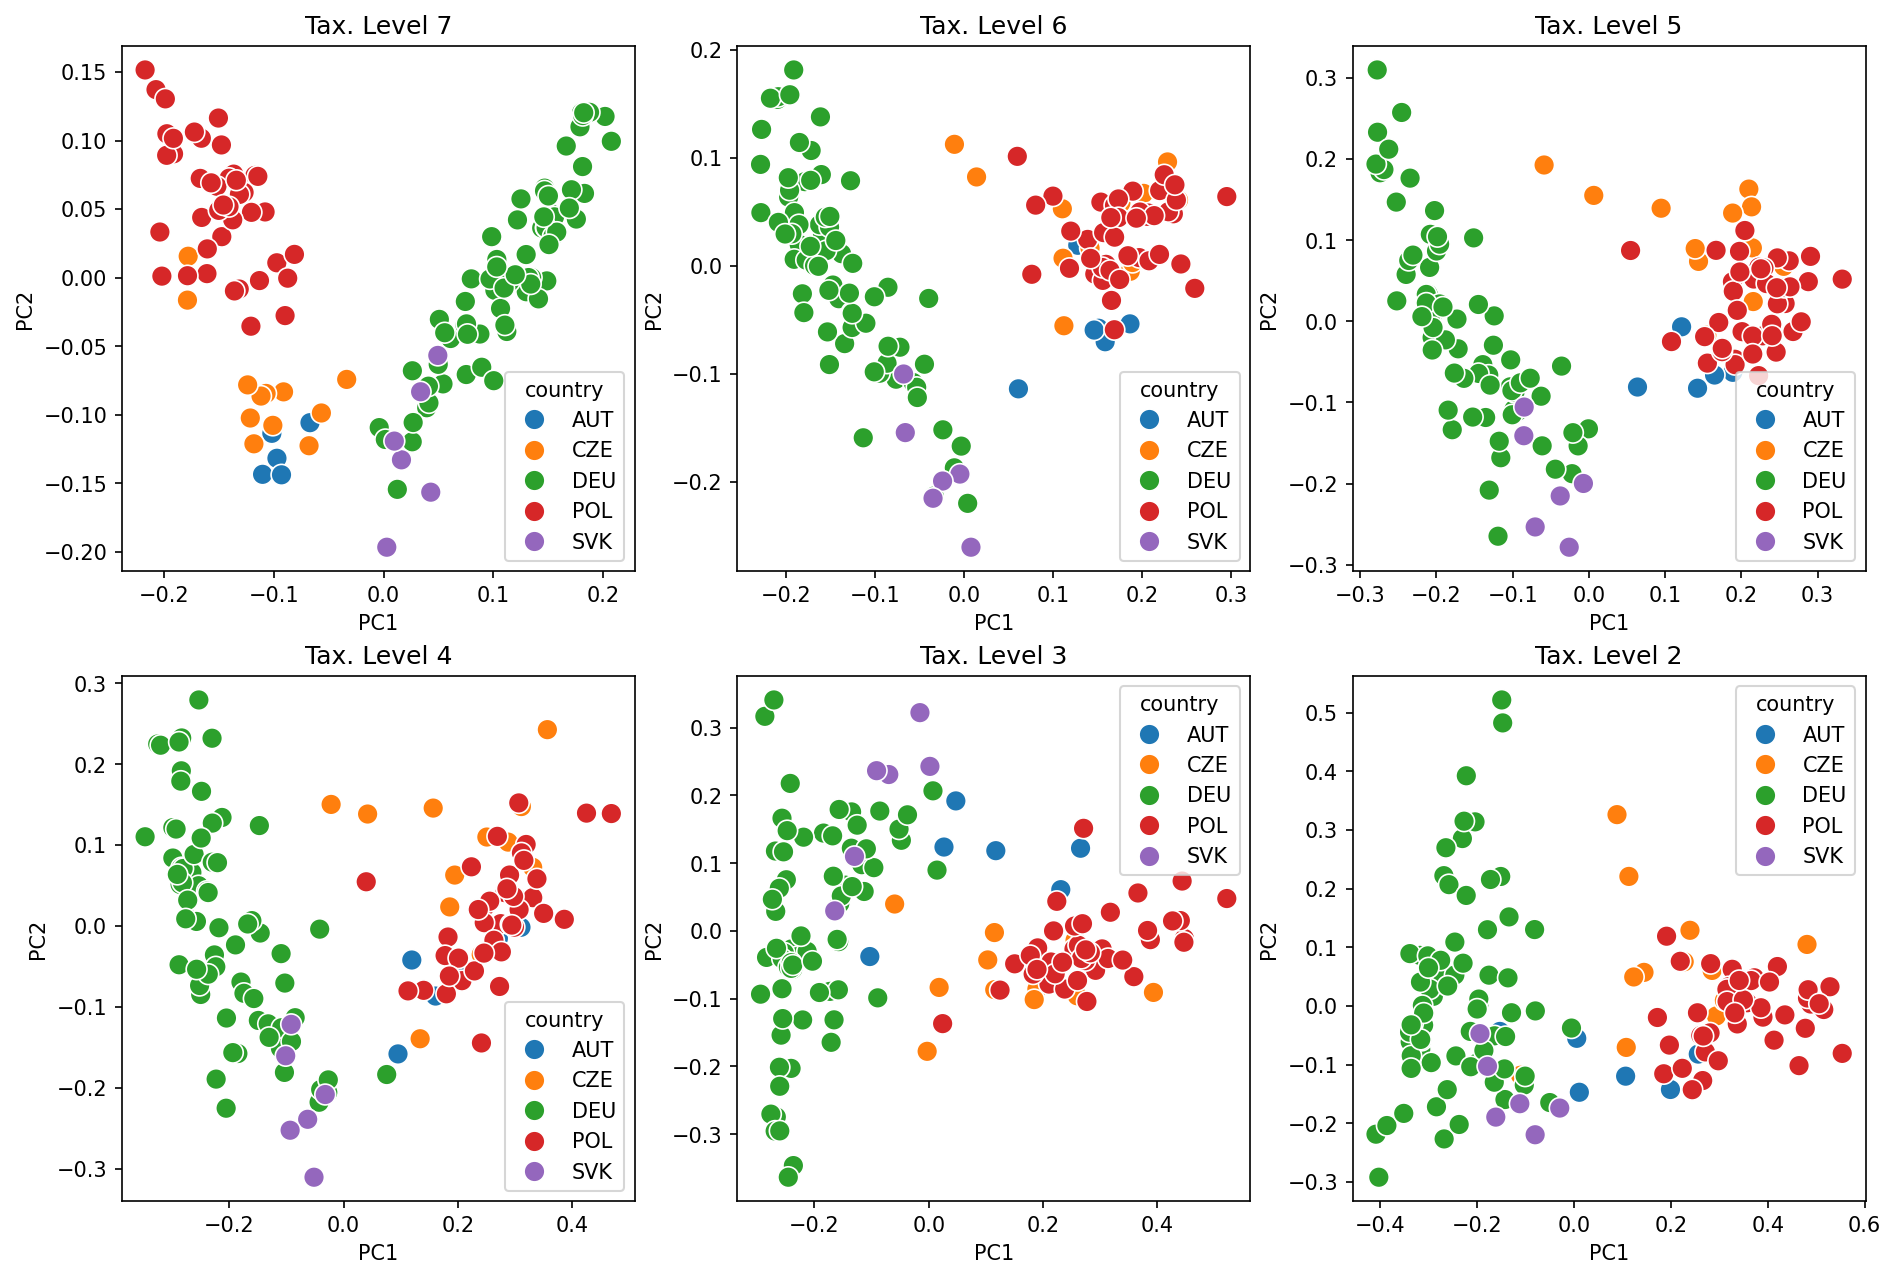

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

for level, ax in zip(range(7, 1, -1), axes.flatten()):
    df = generate_pca_plot_at_level(all_fua_buildings, level)
    sns.scatterplot(x="PC1", y="PC2", hue='country', data=df, s=100, ax=ax)
    ax.set_title(f'Tax. Level {level}')

Assign a geometry, to try out different coloring schemes based on political boundaries.

In [32]:

level=7
df = generate_pca_plot_at_level(all_fua_buildings, level)
# assign a geometry
gdf_fuas = gpd.GeoDataFrame(df, geometry=fuas.set_index('eFUA_name').loc[df['city'].values, 'geometry'].values)

[0.01710804 0.00593765 0.00471977] [0.31507762 0.10935323 0.08692371]


In [56]:
# read boundaries
layer_names = gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name.values.tolist()

In [58]:
layer_names.remove('1300_ostsiedlung')
layer_names.remove('1900_germans')

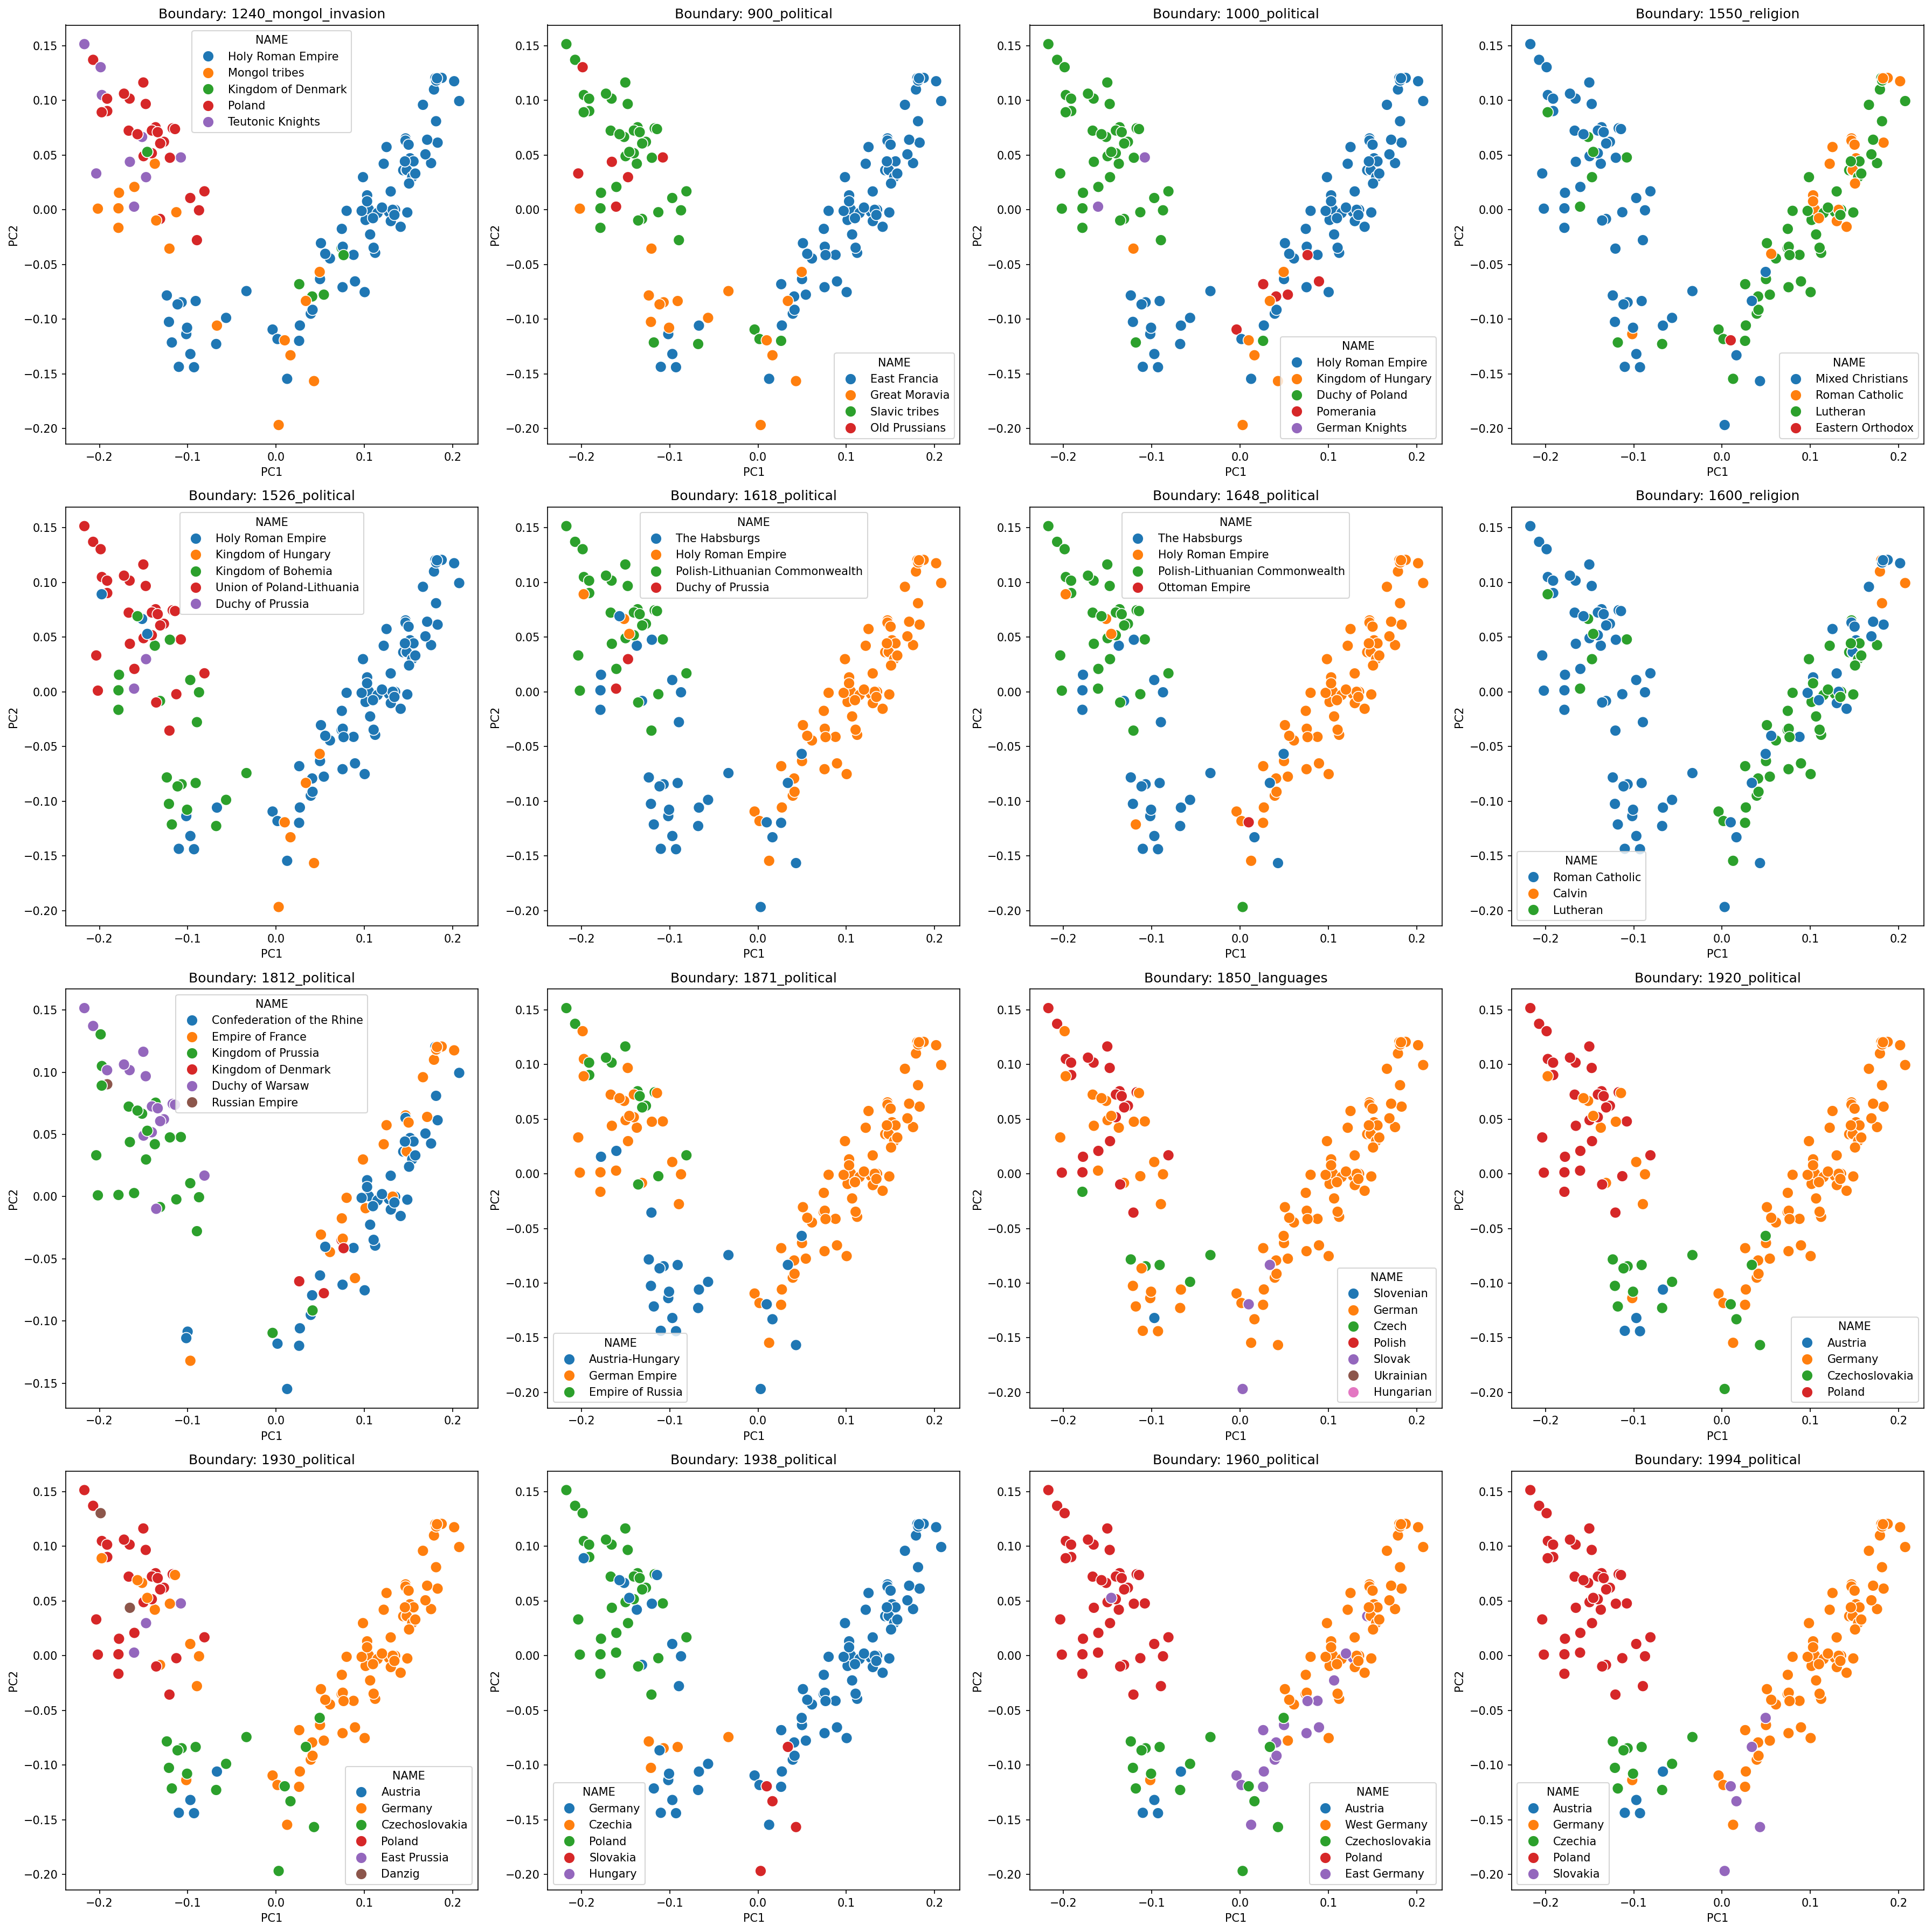

In [60]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24), dpi=150)

for layer, ax in zip(layer_names, axes.flatten()):

    boundaries = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg', layer=layer)
    new_df = gdf_fuas.sjoin(boundaries)
    sns.scatterplot(x="PC1", y="PC2", hue='NAME', data=new_df, s=100, ax=ax)
    ax.set_title(f'Boundary: {layer}')

fig.tight_layout()

Assign population to a PCA dataframe

In [39]:

level=7
df = generate_pca_plot_at_level(all_fua_buildings, level)
population = fuas.set_index('eFUA_name').loc[df['city'].values, 'FUA_p_2015'].values
df['population'] = population

[0.01710804 0.00593765 0.00471977] [0.31507762 0.10935323 0.08692371]


Assign pca distance to every FUA. The `pca distance sums` is the sum of distances in PCA space, between a FUA and its 5 closest geographical neighbours.
The value is higher, for those FUA that are further away from their 5 closest geographical neighbours.

In [40]:
from libpysal.graph import Graph
from scipy.spatial.distance import cdist

In [41]:
pca_df = df[['PC1', 'PC2', 'city']].set_index('city')

city_centroids = fuas.set_index('eFUA_name').loc[df['city'].values, 'geometry'].centroid
spatial_graph = Graph.build_kernel(city_centroids, kernel='identity', k=5)

pca_distance_sums = {}
for focal, neighbours in spatial_graph.adjacency.groupby(level=0):
    neighbours = neighbours.index.get_level_values(1).values
    pca_distance_sum = cdist(pca_df.loc[[focal]].values, pca_df.loc[neighbours].values)[0].sum()
    pca_distance_sums[focal] = pca_distance_sum

df['pca_distance_sums'] = (pd.Series(pca_distance_sums) * 1_000).loc[df.city].values

<Axes: xlabel='PC1', ylabel='PC2'>

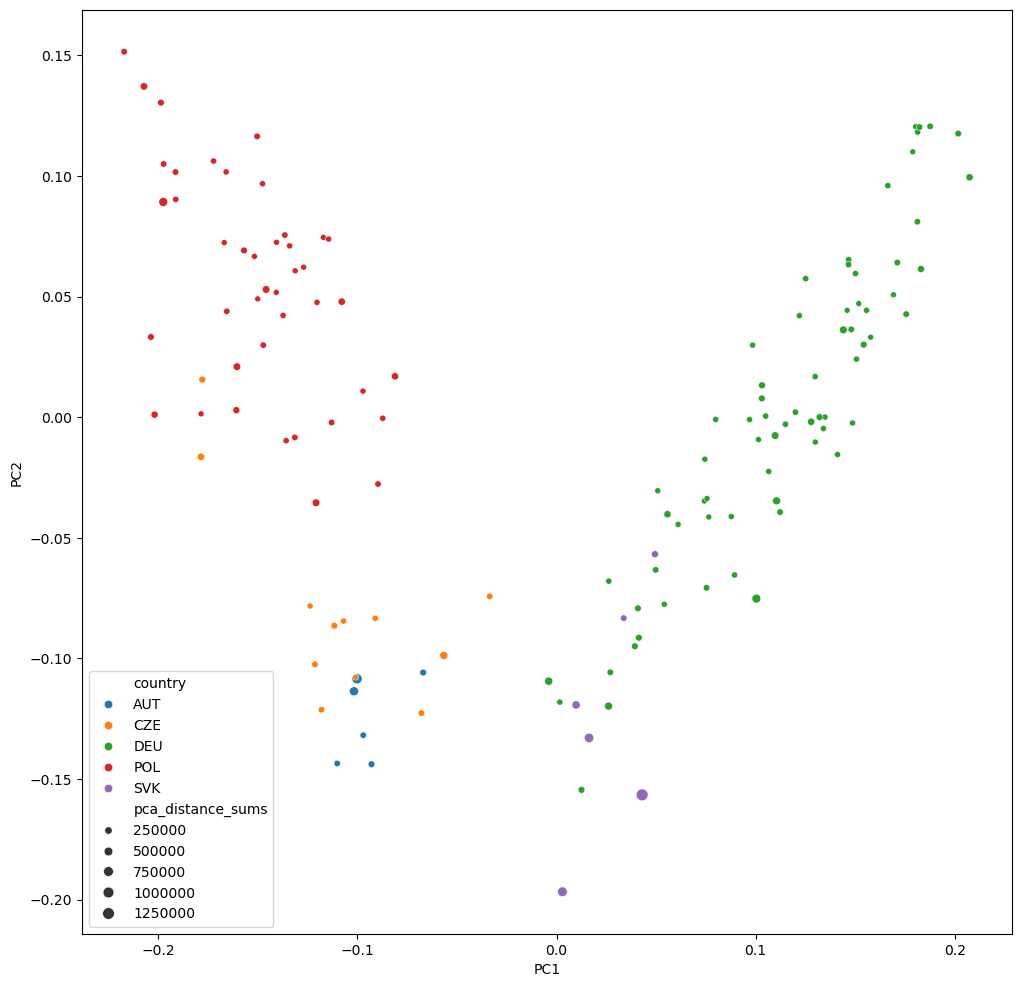

In [42]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x="PC1", y="PC2", hue='country', data=df,  size=df['pca_distance_sums']**2, ax=ax)

Interactive plot.

In [61]:
boundaries = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg', layer='1648_political')
new_df = gdf_fuas.sjoin(boundaries)

In [ ]:
import jscatter
scatter = jscatter.Scatter(data=new_df, x='PC1', y='PC2', color_by='NAME', tooltip=True, tooltip_properties=["city", "NAME"])
scatter.background('#1E1E20')

scatter.show()